<a href="https://colab.research.google.com/github/shelleyg-bit/canada-land-cover-classifier/blob/main/prepare_canada_lc_clipped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Dependencies

In [1]:
!pip install geopandas
!pip install rasterio
!pip install rasterstats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 6.5 MB/s 
     |████████████████████████████████| 6.3 MB 27.5 MB/s 
     |████████████████████████████████| 16.7 MB 196 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 130 kB 7.7 MB/s 


# Load AOI geometries

In [ ]:
import geopandas as gpd

In [ ]:
aoi_gdf = gpd.read_file('/content/drive/MyDrive/nrcan/lc_sample_polygons.json')

In [ ]:
aoi_gdf

,id,geometry
0,0,"POLYGON ((-124.66685 49.28930, -124.57540 49.1..."
1,1,"POLYGON ((-117.79729 51.68682, -117.21066 50.5..."
2,2,"POLYGON ((-114.85822 53.94068, -114.30455 52.7..."
3,3,"POLYGON ((-108.78560 54.77218, -108.48123 53.5..."
4,4,"POLYGON ((-101.93605 55.94701, -101.69793 53.0..."
5,5,"POLYGON ((-114.41815 59.36755, -113.64326 58.0..."
6,6,"POLYGON ((-97.76981 58.55785, -97.99199 57.432..."
7,7,"POLYGON ((-76.52918 60.33521, -77.64478 58.265..."
8,8,"POLYGON ((-73.84157 47.29293, -74.55903 45.696..."
9,9,"POLYGON ((-79.08151 46.64300, -79.40903 45.824..."


In [ ]:
aoi_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

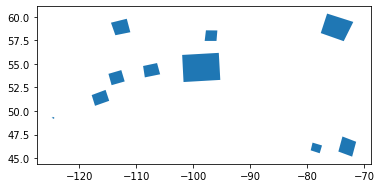

In [ ]:
aoi_gdf.plot()

# Prepare Bounding boxes

In [ ]:
aoi_gdf['geometry'][0].bounds

(-124.6668464, 49.1560322, -124.3173624, 49.3679093)

In [ ]:
def getFeatures(gdf, i):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][i]['geometry']]


In [ ]:
a = aoi_gdf.iloc[0]

In [ ]:
a

id                                                          0
geometry    POLYGON ((-124.6668464 49.2893012, -124.575396...
Name: 0, dtype: object

In [ ]:
import rasterio as rio
with rio.open('/content/drive/MyDrive/nrcan/CanadaLandcover2015/CAN_LC_2015_CAL.tif', 'r') as src:
  lc_profile = src.profile.copy()

In [ ]:
lc_profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 190001, 'height': 160001, 'count': 1, 'crs': CRS.from_epsg(3978), 'transform': Affine(30.0, 0.0, -2600030.0,
       0.0, -30.0, 3914940.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [ ]:
aoi_gdf = aoi_gdf.to_crs(crs=lc_profile['crs'])

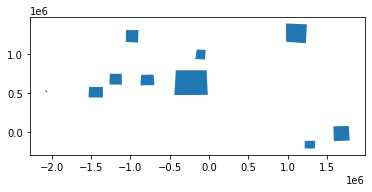

In [ ]:
aoi_gdf.plot()

In [ ]:
aoi_gdf

,id,geometry
0,0,"POLYGON ((-2078461.775 525851.297, -2079164.36..."
1,1,"POLYGON ((-1528308.426 574253.283, -1533684.50..."
2,2,"POLYGON ((-1262181.542 743606.545, -1267557.99..."
3,3,"POLYGON ((-864091.042 729921.385, -873133.897 ..."
4,4,"POLYGON ((-423357.886 787227.486, -441930.270 ..."
5,5,"POLYGON ((-1057515.738 1298464.453, -1058249.0..."
6,6,"POLYGON ((-156986.423 1051399.341, -175314.696..."
7,7,"POLYGON ((977411.353 1383508.172, 980345.409 1..."
8,8,"POLYGON ((1582000.521 75113.149, 1586887.787 -..."
9,9,"POLYGON ((1217878.553 -110125.136, 1215679.165..."


In [ ]:
out_dir = '/content/drive/MyDrive/nrcan/lc_data'

In [ ]:
with rio.open('/content/drive/MyDrive/nrcan/CanadaLandcover2015/CAN_LC_2015_CAL.tif', 'r') as src:
  for i, polygon in enumerate(aoi_gdf['geometry']):
    l, b, r, t = polygon.bounds
    #print(l,b, r,t, *(polygon.bounds))
    win_aoi = rio.windows.from_bounds(*(polygon.bounds), transform=lc_profile['transform'])
    lc_aoi = src.read(1, window=win_aoi)
    #print(lc_aoi.shape)
    profile_aoi = src.profile.copy()
    profile_aoi['width'] = win_aoi.width #lc_aoi.shape[1]
    profile_aoi['height'] = win_aoi.height #lc_aoi.shape[0]
    profile_aoi['transform'] = src.window_transform(win_aoi)
    profile_aoi['nodata'] = 255
    print(profile_aoi)
    with rio.open(f'{out_dir}/aoi{i}_lc.tif', 'w', **profile_aoi) as dst:
      dst.write(lc_aoi, indexes=1)




{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255, 'width': 704.6205995790515, 'height': 545.7754046099872, 'count': 1, 'crs': CRS.from_epsg(3978), 'transform': Affine(30.0, 0.0, -2079164.3628934254,
       0.0, -30.0, 526004.0329663577), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255, 'width': 6125.7185431543985, 'height': 4496.535855634022, 'count': 1, 'crs': CRS.from_epsg(3978), 'transform': Affine(30.0, 0.0, -1533684.509203629,
       0.0, -30.0, 576208.2823371678), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255, 'width': 5278.544991917101, 'height': 4594.290808175574, 'count': 1, 'crs': CRS.from_epsg(3978), 'transform': Affine(30.0, 0.0, -1267557.9918498895,
       0.0, -30.0, 743606.544866452), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'ban

# Zonal Stats of Land cover classes

In [ ]:
!pip install rasterstats

     |████████████████████████████████| 130 kB 5.1 MB/s 


{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 8911, 'height': 8390, 'count': 1, 'crs': CRS.from_epsg(3978), 'transform': Affine(30.0, 0.0, 977411.3533277651,
       0.0, -30.0, 1383508.17194285), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


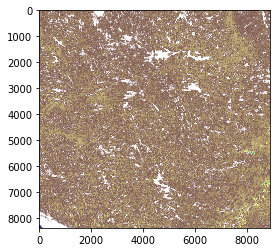

In [ ]:
from rasterstats import zonal_stats, gen_zonal_stats
import matplotlib.pyplot as plt

with rio.open(f'{out_dir}/aoi7_lc.tif', 'r') as src:
  lc = src.read(1)
  print(src.profile)
plt.imshow(lc, cmap='terrain')

In [ ]:
import operator
stats = ['majority','unique', 'percentile_10', 'percentile_50', 'percentile_80']
for i, polygon in enumerate(aoi_gdf['geometry']): 
  aoi_lc_stats = zonal_stats(polygon, raster=f'{out_dir}/aoi{i}_lc.tif', stats=stats, categorical=True)[0]
  #sorted_stats = sorted(aoi_lc_stats.items(), key=operator.itemgetter(1))
  print([(key, aoi_lc_stats[key]) for key in stats])
  [aoi_lc_stats.pop(stat) for stat in stats]
  sorted_stats_lc_types = sorted(aoi_lc_stats.items(), key=operator.itemgetter(1), reverse=True)
  print(sorted_stats_lc_types)

[('majority', 1.0), ('unique', 10), ('percentile_10', 1.0), ('percentile_50', 5.0), ('percentile_80', 8.0)]
[(1, 174003), (6, 81623), (8, 42771), (17, 18714), (10, 11810), (16, 11583), (18, 8869), (5, 7945), (15, 4696), (19, 25)]
[('majority', 1.0), ('unique', 14), ('percentile_10', 1.0), ('percentile_50', 5.0), ('percentile_80', 16.0)]
[(1, 12712077), (16, 6331869), (10, 2492948), (8, 1418301), (19, 1311906), (6, 665200), (2, 524722), (5, 441445), (18, 379497), (17, 152233), (14, 145115), (15, 125495), (12, 16273), (11, 7884)]
[('majority', 15.0), ('unique', 11), ('percentile_10', 5.0), ('percentile_50', 15.0), ('percentile_80', 15.0)]
[(15, 16199622), (5, 2343415), (17, 1591148), (18, 1452661), (8, 1070594), (6, 355459), (10, 223413), (1, 212266), (14, 71903), (16, 44656), (19, 21)]
[('majority', 1.0), ('unique', 11), ('percentile_10', 1.0), ('percentile_50', 6.0), ('percentile_80', 14.0)]
[(1, 7303311), (5, 5002294), (6, 3224723), (18, 2995640), (8, 2884222), (14, 1680346), (15, 112

### aoi1_lc.tif seems to be most diverse land cover

# Re-Sample AOIs
- Some AOIs are too large - which results in large sentinel images and maybe be too large for RAM
- resampling LC data tifs into smaller AOIs based on their diversity.
- Select AOIs where there are atleast 10 land cover types with atleast few of land cover types having 30,000 pixels each

In [13]:
import rasterio as rio
from rasterio.features import Window
from rasterstats import zonal_stats
import numpy as np
import operator

from matplotlib import pyplot as plt

lc_data_dir = '/content/drive/MyDrive/nrcan/lc_data'
lc_filenames = [f'aoi{i}_lc' for i in [0,4,5,8,10]]
sample_threshold = 30000
land_type_threshold = 10

write = True
sample_count = 0

aoi_size = 512 # in pixels, power of 2 for future use of CNN
for lc_filename in lc_filenames:
  with rio.open(f'{lc_data_dir}/{lc_filename}.tif', 'r') as src:
    lc = src.read(1)
    lc_profile = src.profile.copy()
    max_width = (lc_profile['width'] // aoi_size) * aoi_size
    max_height = (lc_profile['height'] // aoi_size) * aoi_size
    for i in range(max_height // aoi_size):
      row_start = i * aoi_size
      for j in range(max_width // aoi_size):
        col_start = j * aoi_size
        win = Window(col_off=col_start, row_off=row_start, width=aoi_size, height=aoi_size)
        aoi_lc = src.read(window=win)
        lc_type_values, lc_type_counts = np.unique(aoi_lc, return_counts=True)
        lc_types = {a:b for a,b in zip(lc_type_values, lc_type_counts)}
        sorted_stats_lc_types = sorted(lc_types.items(), key=operator.itemgetter(1), reverse=True)
        percentile = np.percentile(lc_type_counts, q=60)
        unique_types = lc_type_values.shape
        if (percentile >= sample_threshold and unique_types[0] >= land_type_threshold):
          sample_count += 1
          print(f'{lc_filename},{i}{j}, percentile={percentile},\n unique_types={unique_types},\n types={sorted_stats_lc_types}')
          if (write):
            aoi_profile = src.profile.copy()
            aoi_profile['width'] = aoi_size
            aoi_profile['height'] = aoi_size
            aoi_profile['transform'] = src.window_transform(win)
            with rio.open(f'{lc_data_dir}/aoi_512x512/{lc_filename}_{i}{j}', 'w', **aoi_profile) as dst:
              dst.write(aoi_lc)
      



# plt.imshow(lc, cmap='terrain')
print(sample_count)

aoi4_lc,021, percentile=39066.99999999999,
 unique_types=(10,),
 types=[(1, 62457), (8, 49241), (5, 45319), (14, 45313), (6, 34903), (18, 22330), (10, 1788), (17, 702), (2, 49), (16, 42)]
aoi4_lc,220, percentile=35260.2,
 unique_types=(10,),
 types=[(1, 80118), (5, 50193), (14, 41519), (18, 40809), (8, 31561), (6, 10632), (10, 6094), (16, 1178), (2, 24), (12, 16)]
aoi4_lc,820, percentile=36103.6,
 unique_types=(10,),
 types=[(18, 68106), (5, 53391), (1, 48701), (8, 36379), (14, 35920), (6, 16250), (16, 3326), (10, 47), (12, 13), (2, 11)]
aoi4_lc,821, percentile=30282.6,
 unique_types=(10,),
 types=[(1, 89321), (18, 51760), (14, 46197), (8, 31740), (5, 29311), (6, 9894), (16, 2491), (10, 1406), (2, 12), (12, 12)]
aoi4_lc,111, percentile=44353.2,
 unique_types=(10,),
 types=[(18, 55714), (14, 54376), (5, 53527), (1, 47316), (6, 42378), (8, 7352), (16, 975), (10, 491), (12, 10), (17, 5)]
aoi4_lc,1422, percentile=32068.6,
 unique_types=(10,),
 types=[(8, 73312), (1, 50462), (16, 45117), (1